In [ ]:
# 한글 폰트를 위해 실행 후 런타임 다시 할당
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,706 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120874 files and dire

## 구글 드라이브 마운트


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/DataCreatorCamp

/content/drive/MyDrive/Colab Notebooks/DataCreatorCamp


# 데이터 개수 및 분포 확인

In [ ]:
# 필요한 라이브러리 및 모듈 불러오기
import os
from tqdm.notebook import tqdm
from warnings import filterwarnings
filterwarnings('ignore')

import torch
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import models
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

from torch.backends import cudnn
cudnn.benchmark = True

import torchvision
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import seaborn as sns
import unicodedata

In [ ]:
# GPU 사용 가능여부 확인
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# 현재 선택된 디바이스 출력
print(device)

cuda:0


In [ ]:
# kfood_train 경로 설정
kfood_train = './kfood_train'

# 이미지 파일 확장자 리스트
image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

# 디렉토리 내의 각 파일에 대해 이미지 파일 개수 확인
for file_name in os.listdir(kfood_train):
    file_path = os.path.join(kfood_train, file_name)
    if os.path.isdir(file_path):
        image_count = 0
        for entry in os.listdir(file_path):
            entry_path = os.path.join(file_path, entry)
            if os.path.isfile(entry_path) and any(entry.lower().endswith(ext) for ext in image_extensions):
                # 이미지 파일 확장자를 가진 파일을 찾으면 개수를 누적
                image_count += 1
        print(f"파일명: {file_name}, 이미지 개수: {image_count}")

파일명: 갈비구이, 이미지 개수: 810
파일명: 경단, 이미지 개수: 803
파일명: 김밥, 이미지 개수: 789
파일명: 감자전, 이미지 개수: 803
파일명: 갈치구이, 이미지 개수: 809
파일명: 곱창구이, 이미지 개수: 789
파일명: 계란후라이, 이미지 개수: 803
파일명: 고등어구이, 이미지 개수: 812
파일명: 계란말이, 이미지 개수: 796
파일명: 계란국, 이미지 개수: 793
파일명: 누룽지, 이미지 개수: 804
파일명: 꿀떡, 이미지 개수: 810
파일명: 떡국_만두국, 이미지 개수: 799
파일명: 닭갈비, 이미지 개수: 806
파일명: 무국, 이미지 개수: 773
파일명: 김치볶음밥, 이미지 개수: 797
파일명: 김치전, 이미지 개수: 791
파일명: 동그랑땡, 이미지 개수: 819
파일명: 더덕구이, 이미지 개수: 815
파일명: 떡갈비, 이미지 개수: 799
파일명: 알밥, 이미지 개수: 797
파일명: 비빔밥, 이미지 개수: 800
파일명: 송편, 이미지 개수: 799
파일명: 삼겹살, 이미지 개수: 786
파일명: 시래기국, 이미지 개수: 802
파일명: 미역국, 이미지 개수: 802
파일명: 북엇국, 이미지 개수: 801
파일명: 불고기, 이미지 개수: 791
파일명: 새우볶음밥, 이미지 개수: 796
파일명: 생선전, 이미지 개수: 791
파일명: 장어구이, 이미지 개수: 802
파일명: 육개장, 이미지 개수: 788
파일명: 조기구이, 이미지 개수: 803
파일명: 호박전, 이미지 개수: 814
파일명: 유부초밥, 이미지 개수: 799
파일명: 콩나물국, 이미지 개수: 802


In [ ]:
# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 이미지 파일 확장자 리스트
image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]  # 이미지 파일 경로로부터 라벨 추출
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1) # 경로와 라벨 concatenate
    df = df.sample(frac=1, random_state=0).reset_index(drop=True) # index 재설정
    return df

In [ ]:
# 이미지 파일 경로 리스트 생성
image_folder = './kfood_train'
image_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(image_folder) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]

# 데이터프레임 생성
df = proc_img(image_files)

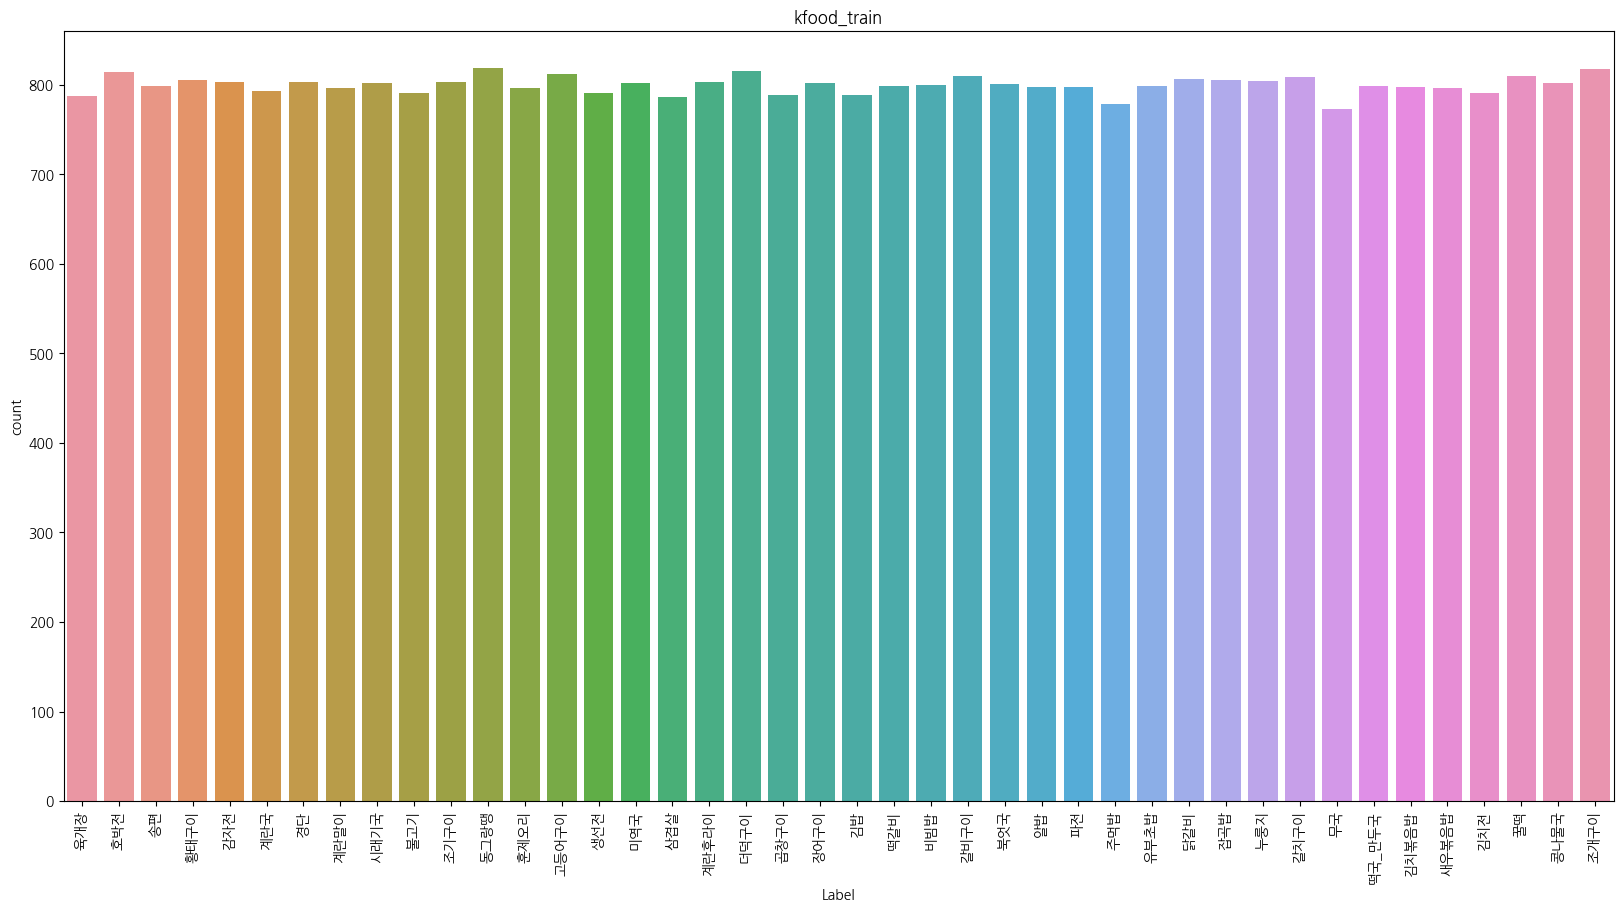

In [ ]:
# 라벨별 카운트 플롯 그리기
plt.subplots(figsize=(20, 10))
sns.countplot(data=df, x='Label')
plt.xticks(rotation=90)  # x 축 라벨을 90도 회전

# 한글 플롯 레이블에 대한 NFC 정규화
ax = plt.gca()
ax.set_xticklabels([unicodedata.normalize('NFC', label.get_text()) for label in ax.get_xticklabels()])
plt.title('kfood_train')

plt.show()

In [ ]:
# kfood_val 경로 설정
kfood_val = './kfood_val'

# 이미지 파일 확장자 리스트
image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

# 디렉토리 내의 각 파일에 대해 이미지 파일 개수 확인
for file_name in os.listdir(kfood_val):
    file_path = os.path.join(kfood_val, file_name)
    if os.path.isdir(file_path):
        image_count = 0
        for entry in os.listdir(file_path):
            entry_path = os.path.join(file_path, entry)
            if os.path.isfile(entry_path) and any(entry.lower().endswith(ext) for ext in image_extensions):
                # 이미지 파일 확장자를 가진 파일을 찾으면 개수를 누적
                image_count += 1
        print(f"파일명: {file_name}, 이미지 개수: {image_count}")

파일명: 고등어구이, 이미지 개수: 93
파일명: 계란국, 이미지 개수: 97
파일명: 감자전, 이미지 개수: 99
파일명: 계란말이, 이미지 개수: 110
파일명: 갈치구이, 이미지 개수: 99
파일명: 갈비구이, 이미지 개수: 85
파일명: 계란후라이, 이미지 개수: 99
파일명: 김밥, 이미지 개수: 111
파일명: 경단, 이미지 개수: 94
파일명: 곱창구이, 이미지 개수: 103
파일명: 동그랑땡, 이미지 개수: 84
파일명: 무국, 이미지 개수: 115
파일명: 떡갈비, 이미지 개수: 103
파일명: 더덕구이, 이미지 개수: 95
파일명: 닭갈비, 이미지 개수: 85
파일명: 누룽지, 이미지 개수: 98
파일명: 김치전, 이미지 개수: 115
파일명: 꿀떡, 이미지 개수: 104
파일명: 떡국_만두국, 이미지 개수: 98
파일명: 김치볶음밥, 이미지 개수: 98
파일명: 시래기국, 이미지 개수: 108
파일명: 미역국, 이미지 개수: 98
파일명: 송편, 이미지 개수: 107
파일명: 불고기, 이미지 개수: 106
파일명: 북엇국, 이미지 개수: 86
파일명: 새우볶음밥, 이미지 개수: 96
파일명: 비빔밥, 이미지 개수: 90
파일명: 삼겹살, 이미지 개수: 111
파일명: 알밥, 이미지 개수: 93
파일명: 생선전, 이미지 개수: 113
파일명: 장어구이, 이미지 개수: 90
파일명: 잡곡밥, 이미지 개수: 103
파일명: 주먹밥, 이미지 개수: 113
파일명: 호박전, 이미지 개수: 85
파일명: 파전, 이미지 개수: 103
파일명: 콩나물국, 이미지 개수: 92
파일명: 조기구이, 이미지 개수: 9

In [ ]:
# 한글 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 이미지 파일 확장자 리스트
image_extensions = ['.jpg', '.jpeg', '.png', '.gif']

def proc_img(filepath):
    labels = [str(filepath[i]).split("/")[-2] for i in range(len(filepath))]  # 이미지 파일 경로로부터 라벨 추출
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    df = pd.concat([filepath, labels], axis=1) # 경로와 라벨 concatenate
    df = df.sample(frac=1, random_state=0).reset_index(drop=True) # index 재설정
    return df

In [ ]:
# 이미지 파일 경로 리스트 생성
image_folder = './kfood_val'
image_files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(image_folder) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]

# 데이터프레임 생성
df = proc_img(image_files)

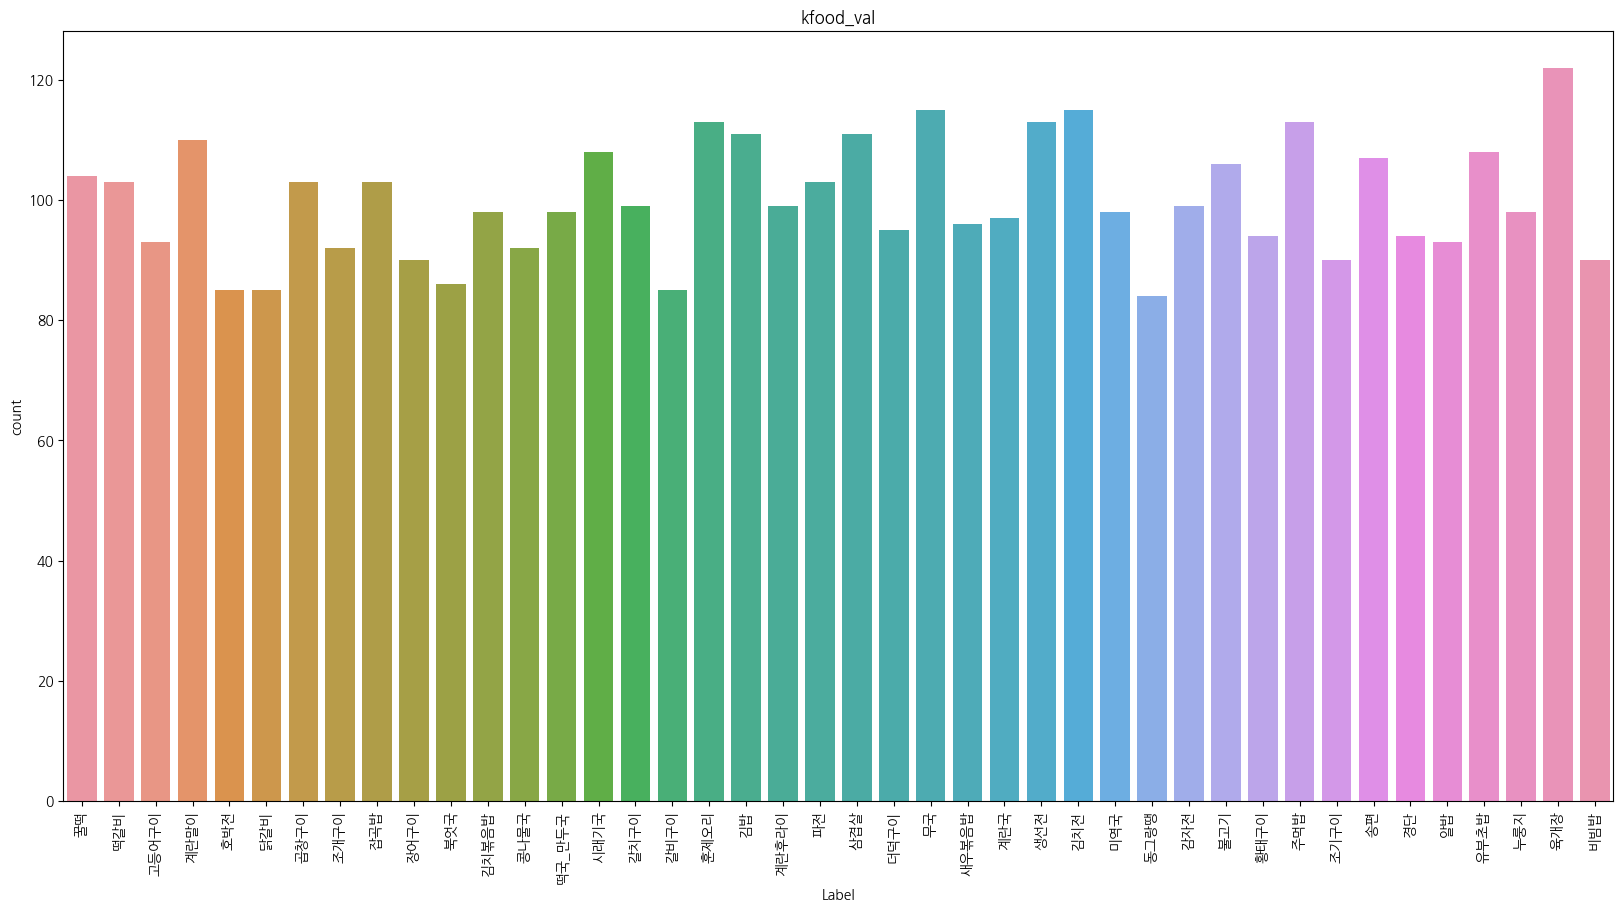

In [ ]:
# 라벨별 카운트 플롯 그리기
plt.subplots(figsize=(20, 10))
sns.countplot(data=df, x='Label')
plt.xticks(rotation=90)  # x 축 라벨을 90도 회전

# 한글 플롯 레이블에 대한 NFC 정규화
ax = plt.gca()
ax.set_xticklabels([unicodedata.normalize('NFC', label.get_text()) for label in ax.get_xticklabels()])
plt.title('kfood_val')

plt.show()

# Mission 1-1

In [ ]:
# 이미지 폴터에서 데이터셋 불러오기
data = ImageFolder(root = "./kfood_train",
                            transform = None)

# 클래스 인덱스를 클래스 이름으로 매핑
labels={b:a for a,b in data.class_to_idx.items()}

# 데이터셋 총 개수
print(len(data))

33593


In [ ]:
# path와 label로 데이터 프레임 만들기
dfs = pd.DataFrame(data.samples,columns=['path','label'])
dfs

,path,label
0,./kfood_train/갈비구이/Img_000_0001.jpg,0
1,./kfood_train/갈비구이/Img_000_0002.jpg,0
2,./kfood_train/갈비구이/Img_000_0003.jpg,0
3,./kfood_train/갈비구이/Img_000_0004.jpg,0
4,./kfood_train/갈비구이/Img_000_0005.jpg,0
...,...,...
33588,./kfood_train/훈제오리/Img_013_0996.jpg,41
33589,./kfood_train/훈제오리/Img_013_0997.jpg,41
33590,./kfood_train/훈제오리/Img_013_0998.jpg,41
33591,./kfood_train/훈제오리/Img_013_0999.jpg,41


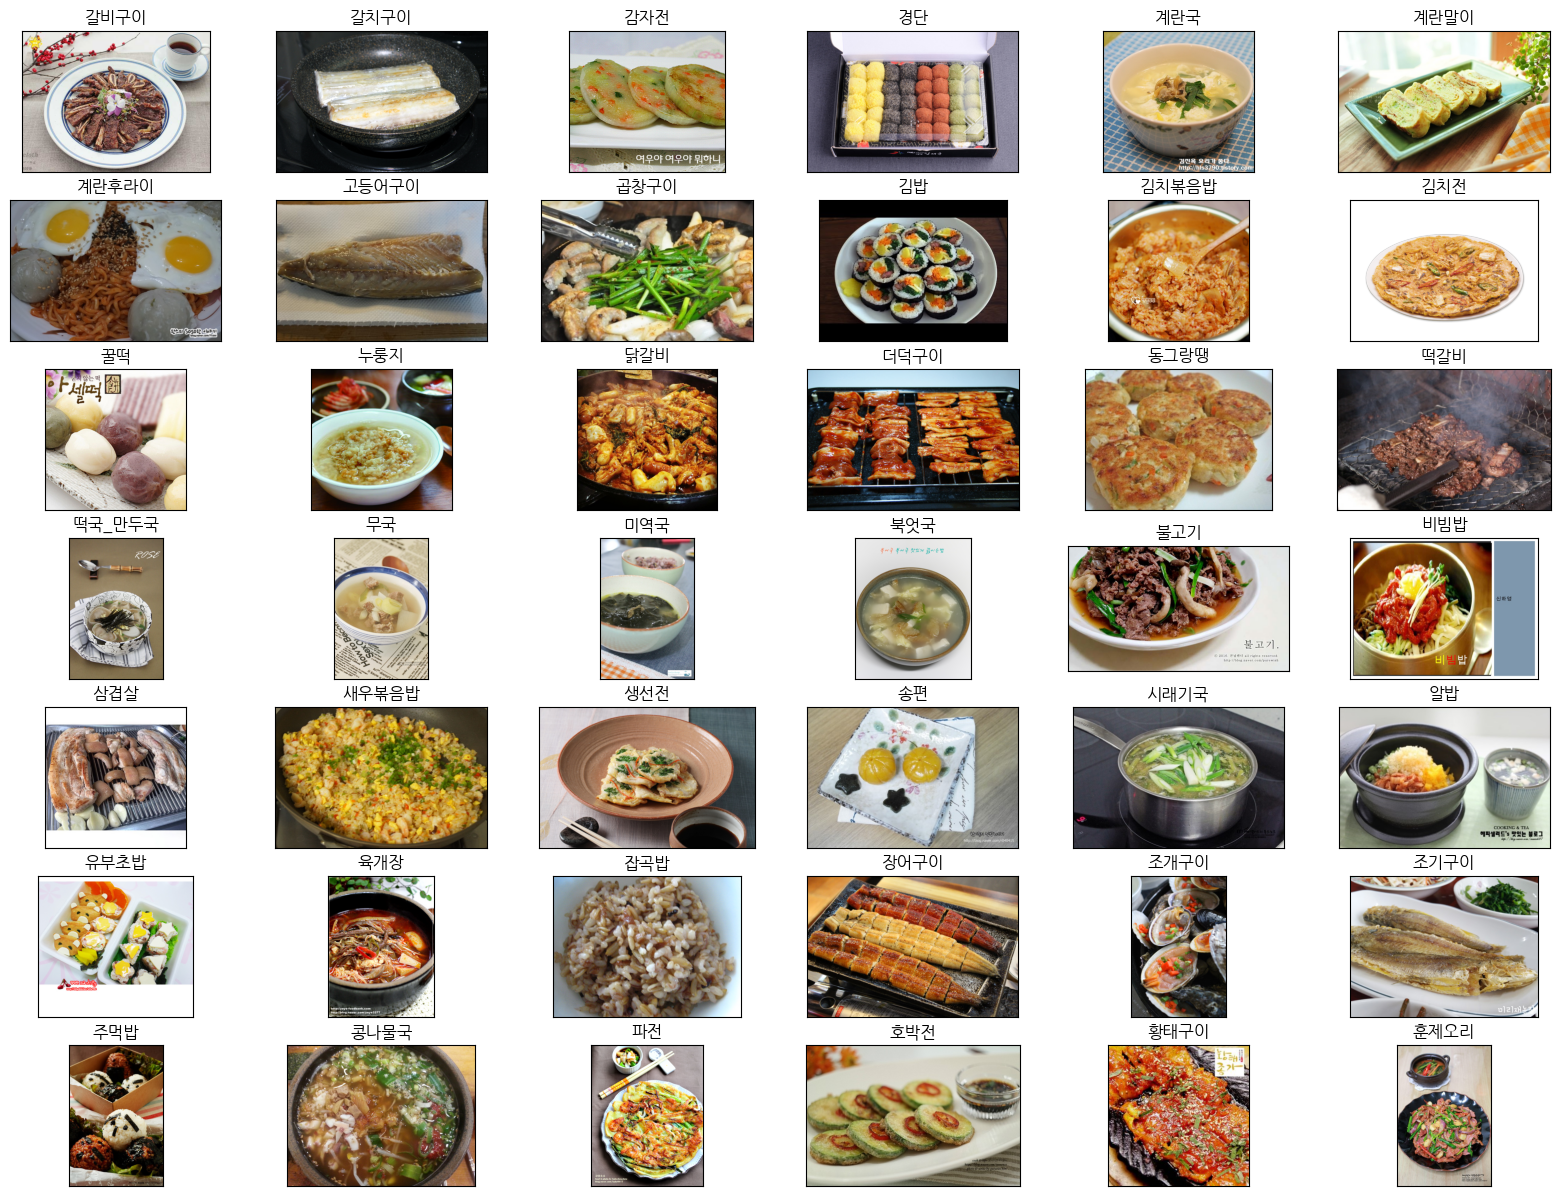

In [ ]:
# 클래스별로 이미지를 하나씩 총 42장 한번에 시각화
rows = 7
cols = 6
plt.figure(figsize=(20,15))
plt.rc('font', family='NanumGothic')

for i in range(42):

    df = dfs[dfs['label']==i]['path']
    img = Image.open(df.iloc[0]) # image

    ttl = df.iloc[0].split('/')[-2]
    ttl = unicodedata.normalize('NFC', ttl) # title

    plt.subplot(rows,cols,i+1)
    plt.imshow(img)
    plt.title(ttl)
    plt.xticks([])
    plt.yticks([])
    i += 1

plt.show()

# Mission 1-2

### load data

In [ ]:
# 데이터 변환 정의
transform = transforms.Compose(
    [transforms.Resize((224,224)), # 이미지 크기 조정
     transforms.ToTensor(), # 이미지를 PyTorch 텐서로 변환
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                  ])

# 데이터셋 불러오기
batch_size = 32

dataset = ImageFolder(root='./kfood_train',
                     transform=transform)
valset = ImageFolder(root='./kfood_val',
                                transform=transform)
valloader = DataLoader(valset,
                        batch_size = batch_size,
                        shuffle=False,
                        num_workers=4)

print(len(dataset))
print(len(valset))

33593
4198


In [ ]:
dataset.class_to_idx.items()

dict_items([('갈비구이', 0), ('갈치구이', 1), ('감자전', 2), ('경단', 3), ('계란국', 4), ('계란말이', 5), ('계란후라이', 6), ('고등어구이', 7), ('곱창구이', 8), ('김밥', 9), ('김치볶음밥', 10), ('김치전', 11), ('꿀떡', 12), ('누룽지', 13), ('닭갈비', 14), ('더덕구이', 15), ('동그랑땡', 16), ('떡갈비', 17), ('떡국_만두국', 18), ('무국', 19), ('미역국', 20), ('북엇국', 21), ('불고기', 22), ('비빔밥', 23), ('삼겹살', 24), ('새우볶음밥', 25), ('생선전', 26), ('송편', 27), ('시래기국', 28), ('알밥', 29), ('유부초밥', 30), ('육개장', 31), ('잡곡밥', 32), ('장어구이', 33), ('조개구이', 34), ('조기구이', 35), ('주먹밥', 36), ('콩나물국', 37), ('파전', 38), ('호박전', 39), ('황태구이', 40), ('훈제오리', 41)])

In [ ]:
classes = dataset.classes

## cross validation : kfood_train을 8:2로 나눠 train과 test로 정의

In [ ]:
# 데이터셋의 크기
dataset_size = len(dataset)

# 데이터셋을 train과 test 8:2로 나누기
train_ratio = 0.8
train_size = int(train_ratio * dataset_size)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(len(train_dataset))
print(len(test_dataset))

26874
6719


In [ ]:
# 학습 데이터로더를 설정
trainloader = DataLoader(train_dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=4)
# 테스트 데이터로더를 설정
testloader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=4)

In [ ]:
print(len(trainloader))
print(len(testloader))

840
210


## using resnet18 train

In [ ]:
# resnet18 파라미터 무작위로 초기화하여 사용
resnet18 = models.resnet18(weights=None)

In [ ]:
# fc layer 수정
fc_in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(fc_in_features,42)
resnet18 = resnet18.to(device)

from torchsummary import summary
summary(resnet18, (3,224,224)) # RGB 3 channel, 224 x 224

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
# criterion, optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(),
                      lr=0.001,
                      momentum=0.9)

In [ ]:
# 학습 중에 정확도와 손실 기록하기
train_accuracy_list = []
train_loss_list = []
test_accuracy_list = []
test_loss_list = []

In [ ]:
# 학습 길이 50 epoch으로 설정하여 학습
for epoch in range(0, 50):
  # train
  running_loss = 0.0
  correct_train = 0
  total_train = 0

  for i,data in enumerate(trainloader, 0):
      # get the inputs ; data is a list of [inputs,labels]
      inputs, labels = data[0].to(device), data[1].to(device)
      # zero the paramet gradients
      optimizer.zero_grad()
      # forward + backward + optimize
      outputs = resnet18(inputs)
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      # print statistics
      running_loss += loss.item()

      # accuracy
      _, predicted = torch.max(outputs.data, 1)
      total_train += labels.size(0)
      correct_train += (predicted == labels).sum().item()
      train_acc = 100*correct_train / total_train

      # train accuracy & loss
      if i% 200 == 199 : # print every 200 mini-batchs
        print(f'[{epoch+1}, {i+1:5d}] accuracy : {train_acc:.2f}% , loss : {running_loss/2000:.3f}')
        running_loss = 0.0

  train_accs = 100 * correct_train / total_train
  train_accuracy_list.append(train_accs)
  train_loss_list.append(running_loss)

  # test accuracy & loss
  with torch.no_grad():
      correct_test = 0
      total_test = 0
      test_loss = 0.0
      for i, data in enumerate(testloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = resnet18(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

  test_acc = 100*correct_test / total_test
  print(f'epoch {epoch+1}: accuracy - {test_acc:.2f}% , loss - {test_loss/len(testloader):.3f}')

  test_accuracy_list.append(test_acc)
  test_loss_list.append(test_loss)


print('Finished Training')

[1,   200] accuracy : 5.53% , loss : 0.357
[1,   400] accuracy : 8.13% , loss : 0.329
[1,   600] accuracy : 10.39% , loss : 0.312
[1,   800] accuracy : 12.14% , loss : 0.301
epoch 1: accuracy - 19.15% , loss - 2.913
[2,   200] accuracy : 20.77% , loss : 0.284
[2,   400] accuracy : 21.57% , loss : 0.277
[2,   600] accuracy : 22.56% , loss : 0.270
[2,   800] accuracy : 23.60% , loss : 0.263
epoch 2: accuracy - 26.88% , loss - 2.596
[3,   200] accuracy : 28.94% , loss : 0.252
[3,   400] accuracy : 29.35% , loss : 0.246
[3,   600] accuracy : 29.90% , loss : 0.240
[3,   800] accuracy : 30.82% , loss : 0.235
epoch 3: accuracy - 32.73% , loss - 2.351
[4,   200] accuracy : 34.48% , loss : 0.225
[4,   400] accuracy : 35.43% , loss : 0.221
[4,   600] accuracy : 35.90% , loss : 0.218
[4,   800] accuracy : 36.61% , loss : 0.211
epoch 4: accuracy - 37.03% , loss - 2.160
[5,   200] accuracy : 40.28% , loss : 0.202
[5,   400] accuracy : 41.00% , loss : 0.201
[5,   600] accuracy : 41.23% , loss : 0.19

In [ ]:
PATH = './mission1.pt'
torch.save(resnet18.state_dict(),PATH) # 지정한 경로에 학습한 파라미터 저장

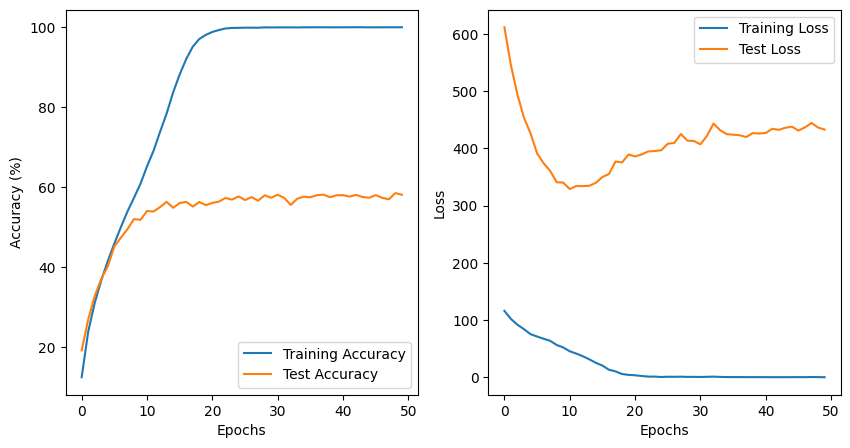

In [ ]:
# 학습 중에 정확도와 손실 기록 시각화
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_list, label='Training Accuracy')
plt.plot(test_accuracy_list, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Training Loss')
plt.plot(test_loss_list, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## top1 accuracy

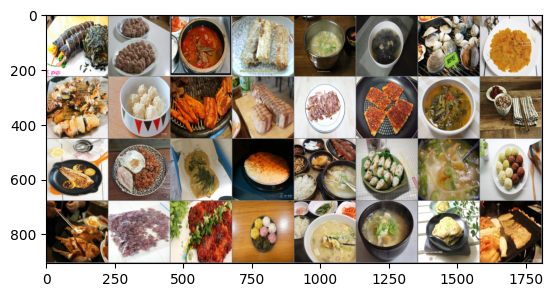

GroundTruth:  김밥 동그랑땡 육개장 갈치구이 북엇국 미역국 조개구이 호박전 장어구이 경단 더덕구이 삼겹살 훈제오리 황태구이 시래기국 잡곡밥 고등어구이 김치볶음밥 생선전 누룽지 황태구이 유부초밥 북엇국 경단 조기구이 누룽지 황태구이 꿀떡 북엇국 북엇국 생선전 삼겹살


In [ ]:
# 테스트 이미지, 라벨 가져오기
dataiter = iter(testloader)
images,labels = next(dataiter)

# imshow 정의
def imshow(img):
  img = img/2 + 0.5 # unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0))) # 다시 H,W,C로 변환
  plt.show()

# 이미지 출력
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(32)))

In [ ]:
outputs = resnet18(images.to(device))

In [ ]:
_,predicted = torch.max(outputs,1) # 각 class의 확률이 가장 높은 것만 출력

# 예측 label 출력
print('Predicted: ',
      ' '.join(f'{classes[predicted[j]]:5s}' for j in range(32)))

Predicted:  김밥 잡곡밥 육개장 갈치구이 북엇국 미역국 조개구이 호박전 장어구이 계란국 닭갈비 떡갈비 훈제오리 황태구이 시래기국 김밥 김치전 김치볶음밥 생선전 계란후라이 장어구이 계란말이 콩나물국 경단 곱창구이 갈비구이 황태구이 꿀떡 콩나물국 북엇국 생선전 삼겹살


In [ ]:
# testloader 정확도 출력
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images,labels = data[0].to(device), data[1].to(device)
    outputs = resnet18(images.to(device))
    _,predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted==labels).sum().item()

print(f'Accuracy of the network on the test images: {100*correct//total} %')

Accuracy of the network on the test images: 58 %


In [ ]:
# 각 클래스별 정확도 계산
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
  for data in testloader:
    images,labels = data[0].to(device), data[1].to(device)
    outputs = resnet18(images.to(device))
    _,predictions = torch.max(outputs.data,1)
    for label, prediction in zip(labels,predictions):
      if label == prediction:
        correct_pred[classes[label]] += 1
      total_pred[classes[label]] += 1

# 각 클래스별 정확도 출력
for classname, correct_count in correct_pred.items():
  accuracy = 100*float(correct_count)/total_pred[classname]
  print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 갈비구이 is 47.5 %
Accuracy for class: 갈치구이 is 57.2 %
Accuracy for class: 감자전 is 46.5 %
Accuracy for class: 경단 is 57.8 %
Accuracy for class: 계란국 is 73.2 %
Accuracy for class: 계란말이 is 42.2 %
Accuracy for class: 계란후라이 is 67.3 %
Accuracy for class: 고등어구이 is 40.4 %
Accuracy for class: 곱창구이 is 45.9 %
Accuracy for class: 김밥 is 63.0 %
Accuracy for class: 김치볶음밥 is 61.9 %
Accuracy for class: 김치전 is 69.4 %
Accuracy for class: 꿀떡 is 80.9 %
Accuracy for class: 누룽지 is 60.4 %
Accuracy for class: 닭갈비 is 51.4 %
Accuracy for class: 더덕구이 is 60.7 %
Accuracy for class: 동그랑땡 is 43.2 %
Accuracy for class: 떡갈비 is 52.4 %
Accuracy for class: 떡국_만두국 is 61.3 %
Accuracy for class: 무국 is 65.4 %
Accuracy for class: 미역국 is 87.6 %
Accuracy for class: 북엇국 is 55.6 %
Accuracy for class: 불고기 is 51.7 %
Accuracy for class: 비빔밥 is 45.0 %
Accuracy for class: 삼겹살 is 47.3 %
Accur

### 시각화

In [ ]:
# 각 클래스별 맞춘 샘플, 틀린 샘플 구별
correct_samples = {classname: [] for classname in classes}
incorrect_samples = {classname: [] for classname in classes}

with torch.no_grad():
  for data in testloader:
    images, labels = data[0].to(device), data[1].to(device)
    outputs = resnet18(images.to(device))
    _, predictions = torch.max(outputs.data, 1)

    for label, prediction, image in zip(labels, predictions, images):
      classname = classes[label]
      if label == prediction:
        correct_samples[classname].append(image.cpu())
      else:
        incorrect_samples[classname].append(image.cpu())

### validation 채점 : kfood_val 데이터 사용해서 정확도 측정

In [ ]:
# 채점시 사용되는 코드
@torch.no_grad()
def validate_epoch(model: nn.Module, data_loader: DataLoader, device: torch.device):
    ''' data_loader provides inputs and GTs.
        model receives input images from data_loader and produces logits.
        returns the accuracy of model in percent.
    '''
    model.eval()
    accuracies = []
    for images, labels in tqdm(data_loader, total=len(data_loader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        accuracies.append(pred == labels)

    accuracy = torch.concat(accuracies).float().mean() * 100
    return accuracy.item()

In [ ]:
validate_epoch(resnet18,valloader,device)

measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

60.64793014526367

# checkpoint loader

In [ ]:
import torch.optim as optim
PATH = './mission1.pt'

# 모델 초기화
resnet18 = models.resnet18()

fc_in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(fc_in_features,42)
resnet18 = resnet18.to(device)
resnet18.eval()

optimizer = optim.SGD(resnet18.parameters(),
                      lr=0.001,
                      momentum=0.9)
resnet18.load_state_dict(torch.load(PATH))

In [ ]:
resnet18 = resnet18.to(device)

In [ ]:
# 채점시 사용되는 코드
@torch.no_grad()
def validate_epoch(model: nn.Module, data_loader: DataLoader, device: torch.device):
    ''' data_loader provides inputs and GTs.
        model receives input images from data_loader and produces logits.
        returns the accuracy of model in percent.
    '''
    model.eval()
    accuracies = []
    for images, labels in tqdm(data_loader, total=len(data_loader), mininterval=1, desc='measuring accuracy'):
        images = images.to(device)
        labels = labels.to(device)

        logits = model(images)
        pred = torch.argmax(logits, dim=1)

        accuracies.append(pred == labels)

    accuracy = torch.concat(accuracies).float().mean() * 100
    return accuracy.item()

In [ ]:
validate_epoch(resnet18,valloader,device)

measuring accuracy:   0%|          | 0/132 [00:00<?, ?it/s]

60.64793014526367